In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.cluster.vq import kmeans, vq
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

(256, 256)


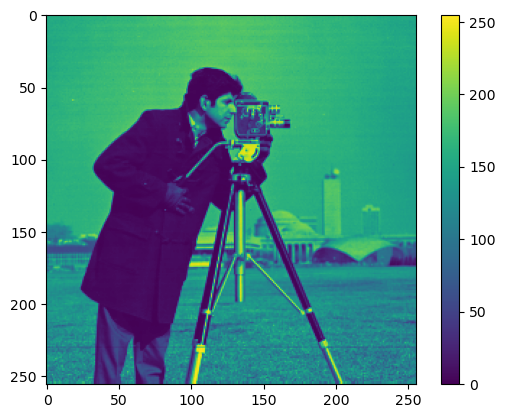

In [4]:
image_number = 3
# dimensionality (N) of subspace = 64
tile_w = 8

image = cv2.imread(f"Dataset/Image{image_number}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(image)
plt.colorbar()
plt.show();

In [35]:
def return_tiles(image, tile_width):
    """
    image: A 2D array
    tile_width: the width of a square tile
    """
    width, height = image.shape

    # Calculate the number of tiles in each dimension
    num_tiles_x = width // tile_width
    num_tiles_y = height // tile_width

    # Initialize an empty array to store tiles
    # Reshape the image into tiles
    tiles = image[:num_tiles_y * tile_width, :num_tiles_x * tile_width].reshape(
        num_tiles_y, tile_width, num_tiles_x, tile_width)

    # Transpose the axes to get the desired shape
    tiles2d = tiles.transpose(0, 2, 1, 3).reshape(num_tiles_y, num_tiles_x, tile_width, tile_width)
    tiles1d = tiles2d.reshape(num_tiles_y*num_tiles_x, tile_width*tile_width)

    return tiles2d, tiles1d

In [36]:
im_tiles2d, im_tiles1d = return_tiles(image, tile_w)
print(im_tiles2d.shape)
print(im_tiles1d.shape)

(32, 32, 8, 8)
(1024, 64)


In [37]:
def visualize_tiles(tiles_array):
    num_tiles_y, num_tiles_x, tile_width, _ = tiles_array.shape

    # Create a subplot with a grid of tiles
    fig, axes = plt.subplots(num_tiles_y, num_tiles_x, figsize=(10, 10))

    # Iterate through each tile and display it in the subplot
    for i in range(num_tiles_y):
        for j in range(num_tiles_x):
            axes[i, j].imshow(tiles_array[i, j, :, :])
            axes[i, j].axis('off')  # Turn off axis labels

    plt.show()

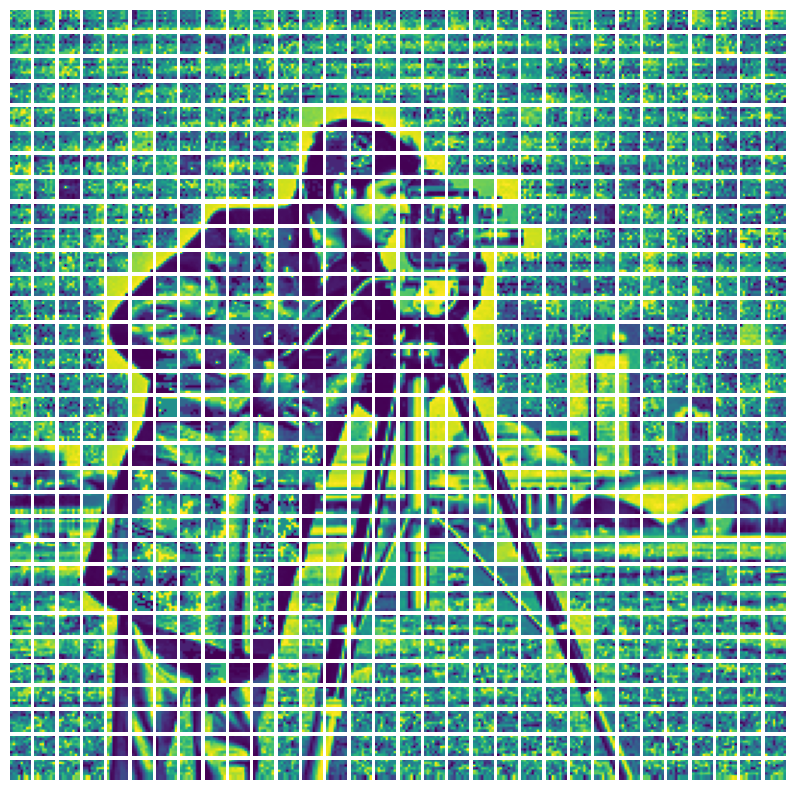

In [38]:
visualize_tiles(im_tiles2d)

centroids shape: (32, 64)
cluster_indices shape: (1024,)


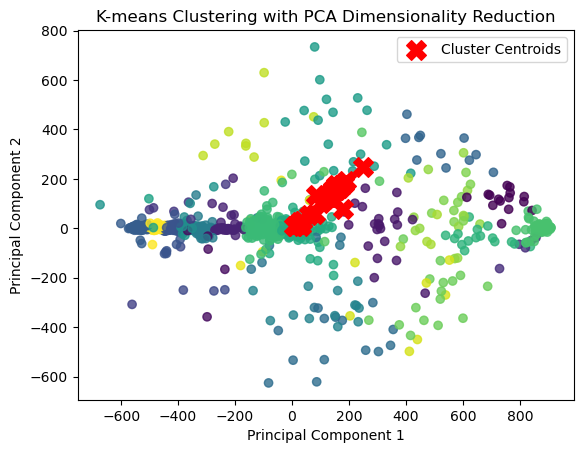

In [54]:
# Perform K-means clustering
# Adjust the number of clusters as needed
num_clusters = 32  
im_tiles1d = im_tiles1d.astype(float)
centroids, _ = kmeans(im_tiles1d, num_clusters)
print('centroids shape:', centroids.shape)

#vector quatization
cluster_indices, _ = vq(im_tiles1d, centroids)
print('cluster_indices shape:', cluster_indices.shape)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
im_tiles1d_reduced = pca.fit_transform(im_tiles1d)

# Visualize the clustering in a 2D plot
plt.scatter(im_tiles1d_reduced[:, 0], im_tiles1d_reduced[:, 1], c=cluster_indices, cmap='viridis', alpha=0.8)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Cluster Centroids')
plt.title('K-means Clustering with PCA Dimensionality Reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Arranging clusters, means and medoids

In [58]:
def calculate_medoid(cluster):
    """
    cluster: an mxN array of m vectors in a cluster
    """
    # Pairwise distances between points in the cluster
    distances = cdist(cluster, cluster, metric='euclidean')
    total_distances = np.sum(distances, axis=1)
    medoid_index = np.argmin(total_distances)

    # Medoid is the data point with the minimum total distance
    medoid = cluster[medoid_index]

    return medoid

def get_cluster_medoids(data, cluster_indices):
    """
    Inputs:
    data: an mxN array of m data vectors (points)
    cluster_indices: an mx1 array of m cluster indices

    Returns:
    clusters: a dictionary, indexed by cluster number and values are clustered arrays of data
    mediods: a dictionary, indexed by cluster number and values are the medoid data vector
    means: a dictionary, '' '' values are means
    
    """
    unique_clusters = np.unique(cluster_indices)

    # Initialise a dictionary to store clusters
    clusters = {cluster: [] for cluster in unique_clusters}

    # Populate clusters dictionary with data points
    for i, cluster_index in enumerate(cluster_indices):
        clusters[cluster_index].append(data[i])

    # Calculate medoid for each cluster
    medoids = {cluster: calculate_medoid(np.array(points)) for cluster, points in clusters.items()}
    means = {cluster: np.mean(np.array(points), axis=0) for cluster, points in clusters.items()}

    return clusters, medoids, means

Centred Clusters

In [80]:
clustered_data, cluster_medoids, cluster_means = get_cluster_medoids(im_tiles1d, cluster_indices)
print ('keys of clustered data' ,clustered_data.keys())
print ('cluster means[0] has shape' , cluster_means[0].shape)
print ('clustered data[0] has shape' ,np.array(clustered_data[0]).shape)

def get_centered_clusters(clustered_data, cluster_means):
    centered_clusters = {cluster: (np.array(clustered_data[cluster])-cluster_means[cluster]) for cluster in clustered_data.keys()}
    return centered_clusters

centered_clusters = get_centered_clusters(clustered_data, cluster_means)

keys of clustered data dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
cluster means[0] has shape (64,)
clustered data[0] has shape (15, 64)


In [86]:
#check for mean zero--> checked
summa = 0
for i in range(32):
    summa += centered_clusters[i].sum()
print (summa)

-2.2595258997171186e-11


In [89]:
def pca_for_cluster(cluster, n=32):
    """ 
    cluster: a centered array of vectors from a single cluster
    """
    assert isinstance(cluster, np.ndarray)

    pca = PCA()
    cluster_pca = pca.fit_transform(cluster)

    # Calculate the cumulative explained variance
    explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

    

    return cluster_pca, explained_variance_ratio_cumulative


# def get_cluster_PCA(centered_clusters, n):
#     """
#     centered_clusters: A dictionary with key- cluster number, value: an array with mean =zero vector
#     n = desired PCA components for each cluster
#     """


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


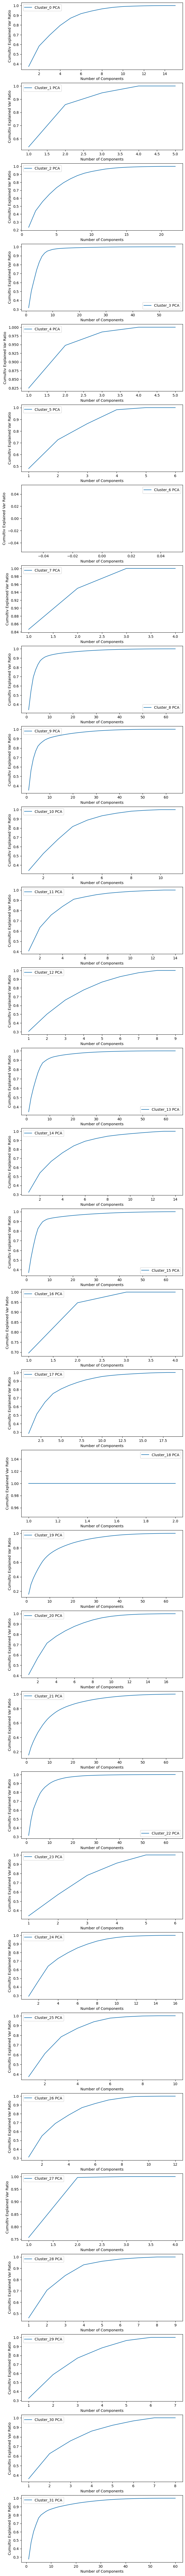

In [98]:
num_clusters = len(centered_clusters)
fig, axs = plt.subplots(nrows= num_clusters, ncols =1, figsize=(8,4* num_clusters))

for i, (cluster_key, points) in enumerate(centered_clusters.items()):
    cluster_pca, expln_var_cum = pca_for_cluster(points)
    axs[i].plot(range(1, len(expln_var_cum) + 1), expln_var_cum, label='Cluster_%d PCA'%(cluster_key))
    axs[i].set_xlabel('Number of Components')
    axs[i].set_ylabel('Cumultiv Explained Var Ratio')
    axs[i].legend()

plt.show()